## Importing and cleaning data

In [110]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks") 

transaction_history_1 = pd.read_csv("../transaction_history_csv/sep-dec.csv")
transaction_history_2 = pd.read_csv("../transaction_history_csv/jun-sep.csv")
transaction_history = pd.concat([transaction_history_1, transaction_history_2])

# transaction_history = transaction_history[transaction_history["Reference"] == "UMC-S"]
transaction_history["Transaction Date"] = pd.to_datetime(transaction_history["Transaction Date"])
transaction_history["Debit Amount"] = transaction_history["Debit Amount"].replace({' ': np.nan})
transaction_history["Debit Amount"] = transaction_history["Debit Amount"].astype(float)
transaction_history["Date"] = transaction_history["Transaction Date"].dt.strftime('%b %d')
transaction_history["Month"] = transaction_history["Transaction Date"].dt.strftime('%m %b')
transaction_history["Vendor"] = transaction_history["Transaction Ref1"].fillna(transaction_history["Transaction Ref2"])

output_directory = "../transaction_history_csv/out.csv"

transaction_history

,Transaction Date,Reference,Debit Amount,Credit Amount,Transaction Ref1,Transaction Ref2,Transaction Ref3,Unnamed: 7,Date,Month,Vendor
0,2024-12-23,ICT,4.60,,OTHR Na,PayNow Transfer 5114586,To: AL HIRA PTE. LTD.,NaN,Dec 23,12 Dec,OTHR Na
1,2024-12-21,ICT,500.00,,OTHR PayNow Transfer,PayNow Transfer 8920040,To: CATALAN KWYNNZIE CHAVEZ,NaN,Dec 21,12 Dec,OTHR PayNow Transfer
2,2024-12-21,ICT,NaN,485.00,OTHR OTHR,Incoming PayNow Ref 1590093,From: CATALAN KWYNNZIE CHAVEZ,NaN,Dec 21,12 Dec,OTHR OTHR
3,2024-12-21,UMC-S,5.76,,NaN,SHENGSIONG@417FERNVALE SI NG 19DEC,5264-7110-0390-7302,NaN,Dec 21,12 Dec,SHENGSIONG@417FERNVALE SI NG 19DEC
4,2024-12-21,UMC-S,15.00,,NaN,KOPITIAM @VIVO SI NG 19DEC,5264-7110-0390-7302,NaN,Dec 21,12 Dec,KOPITIAM @VIVO SI NG 19DEC
...,...,...,...,...,...,...,...,...,...,...,...
126,2024-06-28,ICT,40.00,,PayNow Transfer 9916061,To: SAMUEL SOON,OTHR PayNow Transfer,NaN,Jun 28,06 Jun,PayNow Transfer 9916061
127,2024-06-27,UMC-S,26.40,,7-ELEVEN-COMPASS ONE SI NG 25JUN,5264-7110-1009-8095,NaN,NaN,Jun 27,06 Jun,7-ELEVEN-COMPASS ONE SI NG 25JUN
128,2024-06-27,UMC-S,3.55,,GUARDIAN - COMPASS ONE SI NG 25JUN,5264-7110-1009-8095,NaN,NaN,Jun 27,06 Jun,GUARDIAN - COMPASS ONE SI NG 25JUN
129,2024-06-27,UMC-S,17.30,,SENGKANG POLYCLINIC SI NG 25JUN,5264-7110-1009-8095,NaN,NaN,Jun 27,06 Jun,SENGKANG POLYCLINIC SI NG 25JUN


## Categorizing vendors

In [111]:
def remove_special_characters(string):
    return "".join(e for e in string.lower() if e.isalnum())

def check_if_string_in_list(original_string, reference_list):
    if not isinstance(original_string, str):
        return False
    original_list = [remove_special_characters(s) for s in re.split("\\s+|\.|\@|\*|\/|\_|\-", original_string)]
    return any([x in reference_list for x in original_list])

def categorize_vendors(original_string, reference_dict):
    if not isinstance(original_string, str):
        return "Others"
    original_list = [remove_special_characters(s) for s in re.split("\\s+|\.|\@|\*|\/|\_|\-", original_string)]
    for x in original_list:
        for key, value in reference_dict.items():
            if x in value:
                return key
    return "Shopping"

# F&B vendors list
with open("../restaurants.txt") as restaurants:
    lines = restaurants.readlines()

    restaurant_list = []
    for line in lines:
        line = [remove_special_characters(e) for e in line.split(", ")]
        restaurant_list.extend(line)

    restaurant_list = list(set(restaurant_list))

# Transport vendors list
# Transport, transfers, salary, and medical lists
transport_list = ["bus", "grab"]
transfer_list = ["paynow", "transfer", "ref", "bank", "revolut"]
salary_list = ["mindef", "saf"]
medical_list = ["polyclinic", "clinic"]

# Vendor group dictionary
vendor_groups = {
    "F&B": restaurant_list,
    "Transport": transport_list,
    "Transfers": transfer_list,
    "Salary": salary_list,
    "Medical": medical_list
}

# Transportation vendors list
transaction_history["Category"] = transaction_history["Vendor"].apply(lambda x: categorize_vendors(x, vendor_groups))
output_directory = "../transaction_history_csv/out.csv"
transaction_history["Category"].value_counts()

Category
Shopping     116
Transfers    104
F&B           74
Transport     59
Salary         6
Others         3
Medical        1
Name: count, dtype: int64

In [112]:
def get_price_range(df, upper, lower=-np.inf):
    return df[(df["Debit Amount"] < upper) & (df["Debit Amount"] > lower)] 

def get_category(df, category):
    return df[df["Category"]==category]

def output_csv(df, directory=output_directory):
    df[["Transaction Date", "Vendor", "Category", "Debit Amount", "Credit Amount"]].to_csv(directory, index=False)

def plot_catplot(df):
    fig, axes = plt.subplots(1, 2, figsize=(12,7))
    df = df[(df["Debit Amount"].notna()) & (df["Category"].isin(["Shopping", "F&B"]))]

    month_axis_ordering = sorted(transaction_history["Month"].unique())

    df_aggregated = df[["Month", "Debit Amount"]].groupby("Month").sum()
    sns.lineplot(ax=axes[0], data=df_aggregated, x="Month", y="Debit Amount")

    sns.catplot(ax=axes[1], data=df, x="Month", y="Debit Amount", order=month_axis_ordering)


def plot_debit_amount(df):
    df[["Transaction Date", "Debit Amount"]].set_index("Transaction Date").plot.line()

def plot_monthly_debit_spending(df):
    df = df[df["Debit Amount"].notna()]
    ax = df[["Month", "Debit Amount"]].groupby("Month").sum().plot.bar()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

def plot_spending_histogram(df, bins_count=100):
    df["Debit Amount"].plot.hist(bins=bins_count)

def plot_number_of_transactions_monthly(df):
    df = df[df["Debit Amount"].notna()]
    ax = df[["Month", "Debit Amount"]].groupby("Month").count().plot.bar()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


In [113]:
def get_price_range(df, upper, lower=-np.inf):
    return df[(df["Debit Amount"] < upper) & (df["Debit Amount"] > lower)] 

def get_category(df, category):
    return df[df["Category"]==category]

def output_csv(df, directory=output_directory):
    df[["Transaction Date", "Vendor", "Category", "Debit Amount", "Credit Amount"]].to_csv(directory, index=False)

def plot_catplot(df):
    df = df[(df["Debit Amount"].notna()) & (df["Category"].isin(["Shopping", "F&B"]))]
    month_axis_ordering = sorted(transaction_history["Month"].unique())
    sns.catplot(data=df, x="Month", y="Debit Amount", order=month_axis_ordering)

def plot_debit_amount(df):
    df = df[(df["Debit Amount"].notna()) & (df["Category"].isin(["Shopping", "F&B"]))]
    df[["Transaction Date", "Debit Amount"]].set_index("Transaction Date").plot.line()

def plot_monthly_debit_spending(df):
    df = df[(df["Debit Amount"].notna()) & (df["Category"].isin(["Shopping", "F&B"]))]
    ax = df[["Month", "Debit Amount"]].groupby("Month").sum().plot.bar()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

def plot_spending_histogram(df, bins_count=100):
    df["Debit Amount"].plot.hist(bins=bins_count)

def plot_number_of_transactions_monthly(df):
    df = df[df["Debit Amount"].notna()]
    ax = df[["Month", "Debit Amount"]].groupby("Month").count().plot.bar()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


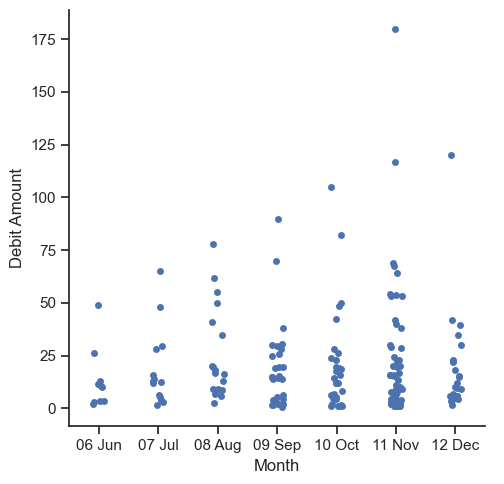

In [114]:
plot_catplot(transaction_history)

## Total spending over time

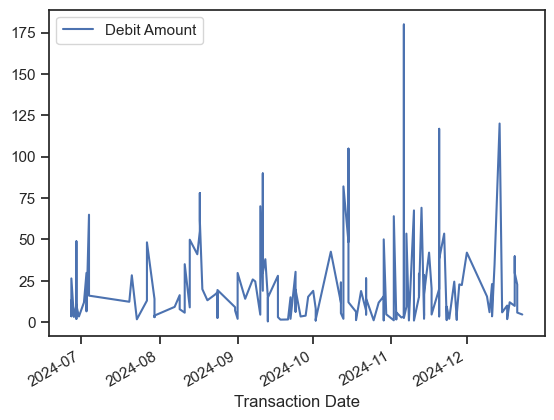

In [115]:
plot_debit_amount(transaction_history)

## Spending on F&B over time

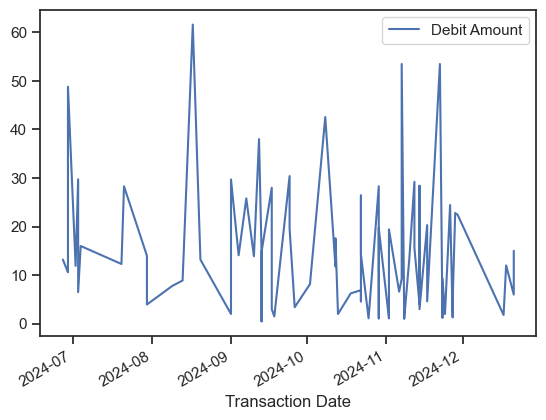

In [116]:
plot_debit_amount(get_category(transaction_history, "F&B"))

## Histogram of total spending

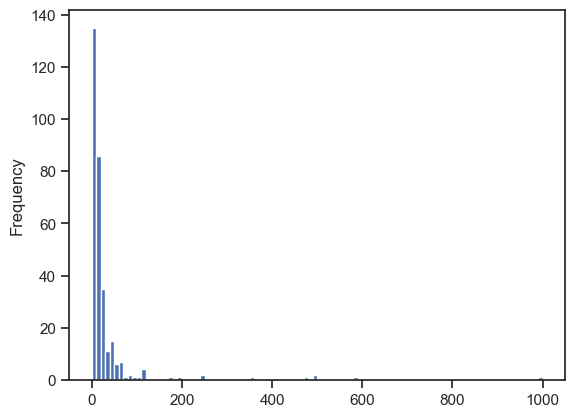

In [117]:
plot_spending_histogram(transaction_history)

## Histogram of spending on F&B

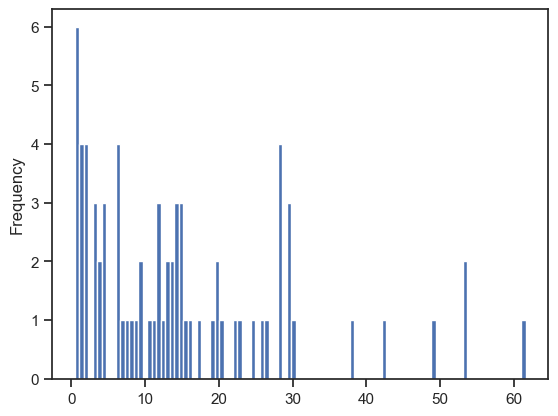

In [118]:
plot_spending_histogram(get_category(transaction_history, "F&B"))

## Monthly spending 

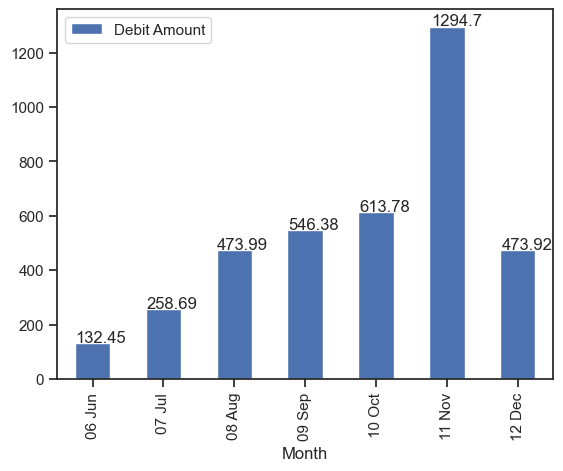

In [119]:
plot_monthly_debit_spending(transaction_history)

## Monthly F&B spending

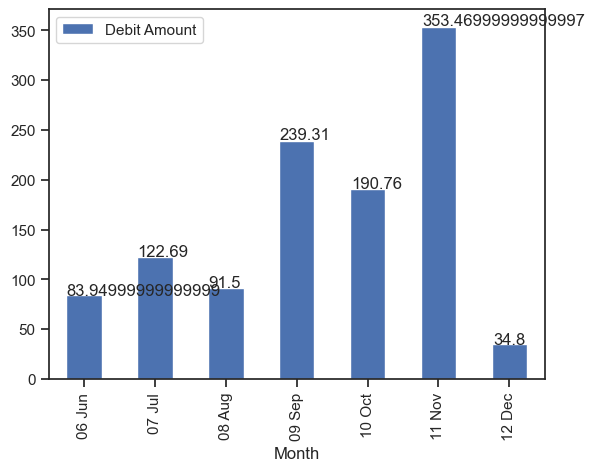

In [120]:
plot_monthly_debit_spending(get_category(transaction_history, "F&B"))

## Monthly total count of transactions

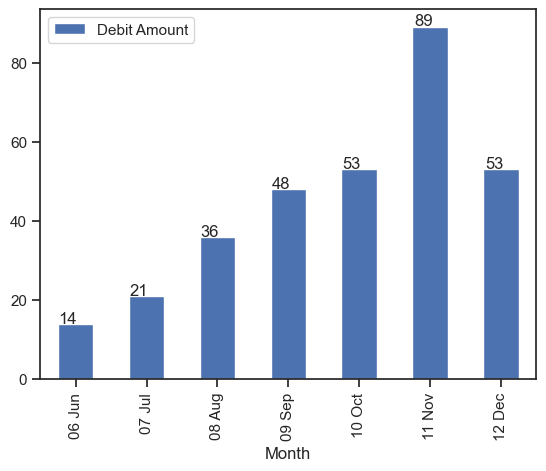

In [121]:
plot_number_of_transactions_monthly(transaction_history)

## Monthly count of transactions on F&B

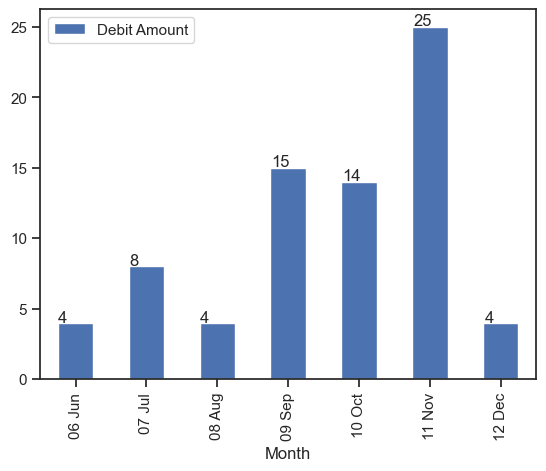

In [122]:
plot_number_of_transactions_monthly(get_category(transaction_history, "F&B"))

## Price bands

In [123]:
df = get_category(transaction_history, "Others")

price_bands = {
    "0-10": float(get_price_range(df, 10)["Debit Amount"].sum()),
    "10-20": float(get_price_range(df, 20, 10)["Debit Amount"].sum()),
    "20-30": float(get_price_range(df, 30, 20)["Debit Amount"].sum()),
    "30-40": float(get_price_range(df, 40, 30)["Debit Amount"].sum()),
    "40-50": float(get_price_range(df, 50, 40)["Debit Amount"].sum()),
    "50+": float(get_price_range(df, np.inf, 50)["Debit Amount"].sum())
}

price_bands

{'0-10': 0.0,
 '10-20': 0.0,
 '20-30': 0.0,
 '30-40': 0.0,
 '40-50': 0.0,
 '50+': 0.0}